In [4]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage

In [5]:
load_dotenv()

True

In [6]:
class ChatState(TypedDict):

    messages: Annotated[list[BaseMessage], add_messages]  # add_messages operator.add ke tarah hi messages ko append karne wala reducer function hai but add_messages from langgraph is more optimized to append BaseMessages (i.e., SystemMessage, HumanMessage and AIMessage)

In [7]:
llm = ChatOpenAI()

def chat_node(state: ChatState):
    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}

In [8]:
graph = StateGraph(ChatState)

graph.add_node("chat_node", chat_node)

graph.add_edge(START, "chat_node")
graph.add_edge("chat_node", END)

chatbot = graph.compile()

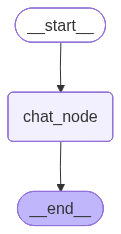

In [9]:
chatbot

In [10]:
while True:
    user_message = input("Type here: ")

    if user_message.lower().strip() in ["exit", "quit", "bye"]:
        break

    print("User:", user_message)

    response = chatbot.invoke({"messages": [HumanMessage(content = user_message)]})

    print("AI:", response["messages"][-1].content)

User: Hi, My name is Rahul!
AI: Hello Rahul! How can I assist you today?
User: What is my name?
AI: I'm sorry, I do not know your name because we have not been formally introduced.


In [1]:
# As we can see above, the chatbot doesn't store the chat history, hence the LLM is not able to recall our previous conversations.
# So, we need to add persistence here.
# We will study persistence in detail in next lecture.
# But for now, persisitence means storing the current state.
# We can store the current state mainly in two places - Memory (RAM) and Database.
# If we store the current state in RAM, then after program execution, the stored state will get deleted.
# But, if we store it in a databse, then it won't get deleted after the program execution ends. So, we can resume our conversation even few days or weeks later.
# But for now, we are storing the state in RAM by the use of MemorySaver
# Note that below code may seem somewhat complex but only because we have not studied persistence yet.
# But after we study persistence in the next lecture, then below codes won't seem hard.

In [12]:
from langgraph.checkpoint.memory import MemorySaver

In [13]:
checkpointer = MemorySaver()

graph = StateGraph(ChatState)

graph.add_node("chat_node", chat_node)

graph.add_edge(START, "chat_node")
graph.add_edge("chat_node", END)

chatbot = graph.compile(checkpointer = checkpointer)

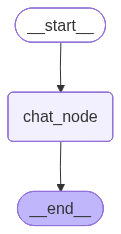

In [14]:
chatbot

In [15]:
thread_id = "1"
# Iss chatbot se multiple log baat kar sakte hain, so har ek insaan ke liye alag thread hota hai.
# Rahul baat kar raha hai toh uske liye ek thread, Rohan baat kar raha hai toh uske liye ek alag thread.
# We will discuss the concept of threads in the next lecture.

while True:
    user_message = input("Type here: ")

    if user_message.lower().strip() in ["exit", "quit", "bye"]:
        break

    print("User:", user_message)

    config = {"configurable": {"thread_id": thread_id}}
    response = chatbot.invoke({"messages": [HumanMessage(content = user_message)]}, config = config)

    print("AI:", response["messages"][-1].content)

User: Hi! My name is Rahul
AI: Hello Rahul! How can I assist you today?
User: What is my name?
AI: Your name is Rahul.
User: What is 100 + 10?
AI: 100 + 10 is equal to 110.
User: Now, multiply the result with 2
AI: Sure! 110 multiplied by 2 is equal to 220.


In [ ]:
# As we can see above, now the LLM knows about our previous conversations.
# Ab har ek iteration mein LangGraph memory se pehle saved state leke aa raha hai.
# Phir 'response = chatbot.invoke({"messages": [HumanMessage(content = user_message)]}, config = config)' line pe diya gaya HumanMessage state ke messages field mein append ho jaa raha hai.
# Then, chat_node function ke return karne pe LLM ka response bhi messages mein append ho jaa raha hai.

In [17]:
# We can also see the state of our config like this - 
chatbot.get_state(config = config)

StateSnapshot(values={'messages': [HumanMessage(content='Hi! My name is Rahul', additional_kwargs={}, response_metadata={}, id='a26e4807-7220-44be-afdc-6242237012d0'), AIMessage(content='Hello Rahul! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 13, 'total_tokens': 23, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-CwRIOb8jR1hwf5Yhm0fYF7DgqfEM1', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019ba7a2-2f20-7e92-81f8-e98ed5a9d455-0', usage_metadata={'input_tokens': 13, 'output_tokens': 10, 'total_tokens': 23, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio

In [18]:
# Now, if you restart the kernel, then this state will be lost as we saved our chat history in memory. That's why production grade chatbots save chat history in an external database.